## Image Classification

This notebook uses a convolutional neural network (CNN) to classify images in Kaggle's MNIST Digit Recognizer data set.  

Image classification is the task of assigning a label or class to an input image. It is a supervised learning problem, where a model is trained on a labeled dataset of images and their corresponding class labels, and then used to predict the class label of new, unseen images.

This notebook 
1. Downloads and reads the Kaggle MNIST training and test datasets, 
2. Builds a CNN to classify the training data,
3. Predicts the test data, and 
4. Provides a confusion matrix and accuracy metrics.  

Source: https://www.kaggle.com/competitions/digit-recognizer/overview

In [28]:
#!pip install pydot-ng
!brew install graphviz
#!pip install --upgrade pip
#!pip install tensorflow
#!python3 -c "import tensorflow as tf; print(tf.reduce_sum(tf.random.normal([1000, 1000])))"

Running `brew update --auto-update`...
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
actions-batch              ignite                     proto
appwrite                   ingress2gateway            protoc-gen-js
argc                       inlyne                     purr
asmfmt                     jnv                        ratchet
autobrr                    jot                        rathole
bluez                      k8sgpt                     rattler-build
bpftop                     kin                        rawdog
c-blosc2                   kiota                      redress
c3c                        ktfmt                      retire
c4core                     kubeshark                  robin-map
cargo-fuzz                 kubetui                    rsyncy
cargo-llvm-cov             libnsbmp                   rtabmap
cargo-sweep                libnsgif                   ruby@3.2
cekit                      liborigin                  

### Import Libraries

In [39]:
import os
from zipfile import ZipFile

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
import graphviz
import pydot_ng as pydot

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers

from keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.callbacks import Callback 
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
from sklearn import metrics

In [7]:
!mkdir ~/.kaggle
!echo '{"username":"sherimichael","key":"******3806"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mkdir: /Users/sherilyn/.kaggle: File exists


In [8]:
os.chdir('/Users/sherilyn/ds_jungle/computer_vision/classification/multiclass/digit_recognizer')
!kaggle competitions download -c digit-recognizer
!ls

 98%|█████████████████████████████████████▏| 15.0M/15.3M [00:00<00:00, 31.0MB/s]
100%|██████████████████████████████████████| 15.3M/15.3M [00:00<00:00, 24.9MB/s]
cnn_digit_recognizer.ipynb       simple_nn_digit_recognizer.ipynb
digit-recognizer.zip


### Download & Read Kaggle date set, MNIST

In [10]:
# Read train & test data
zf = ZipFile('digit-recognizer.zip')
zf.ext')
zf.close()

In [11]:
train = pd.read_csv(r"data/train.csv")
test = pd.read_csv(r"data/test.csv")

### Exploring Data

#### Explore train data

In [12]:
print("train shape:", train.shape)
train.head()

train shape: (42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
#missing data
train.isna().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

Count of Unique Lables:  10
Unique labels:  [1 0 4 7 3 5 8 9 2 6]


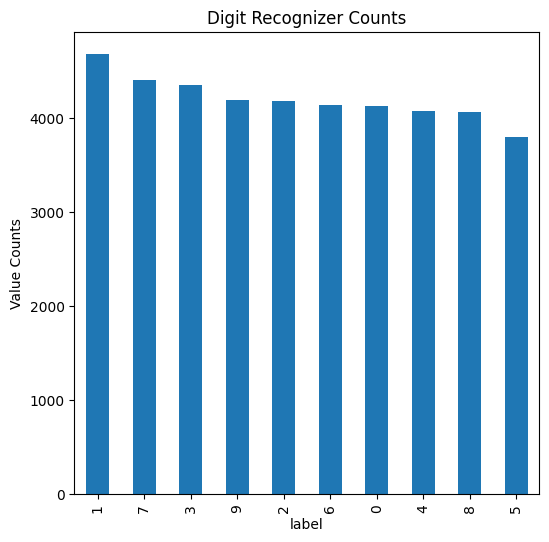

In [14]:
print('Count of Unique Lables: ', train.label.nunique())
print('Unique labels: ', train['label'].unique())
ax = train['label'].value_counts().plot(kind='bar', figsize=(6,6))
fig = ax.get_figure()
ax.set_title("Digit Recognizer Counts")
ax.set_xlabel('label')
ax.set_ylabel('Value Counts');

In [15]:
print("Number of 1: {}".format(len(train[train['label'] == 1])))
print("Number of 5: {}".format(len(train[train['label'] == 5])))

Number of 1: 4684
Number of 5: 3795


Data Summary:

The training data set, train, has 785 columns and 42,000 rows. 
There are no missing data. 
From the data profile on Kaggle, the data set, train, contains gray-scale images of hand-drawn digits, from zero through nine. 
The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image. A value of "0" represents a white image. a value of "1" represents a black image. The data set is relatively balanced for the column, "label"


#### Explore test data

In [16]:
print("test shape:", test.shape)
test.head()

test shape: (28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#missing data
test.isna().sum()

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64

The test data set, test, has 28000 rows and 784 columns. There are no missing data in test.



### Preprocess data

In [17]:
#create target variable, y_train, and feature data, x_train
y_train = train.label
print('y_train.shape: ', y_train.shape)
x_train = train.drop(columns='label')
print('x_train.shape: ', x_train.shape)

y_train.shape:  (42000,)
x_train.shape:  (42000, 784)


In [18]:
#Reshape
#From Kaggle: Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total 
#Normalize pixel values to 0-1 range #From Kaggle: Each pixel-value is an integer between 0 and 255, inclusive.
x_train=x_train.values.reshape(42000,28,28)
x_train=x_train/255
print(x_train.shape)
x_test=test.values.reshape(28000,28,28)
x_test=x_test/255
print(x_test.shape)

(42000, 28, 28)
(28000, 28, 28)


In [19]:
#define input shape
input_shape = (28, 28, 1)

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
print(x_train.shape)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print(x_test.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)


In [20]:
#Label encodings - one hot encode categorical variables
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(10,), dtype=float32)


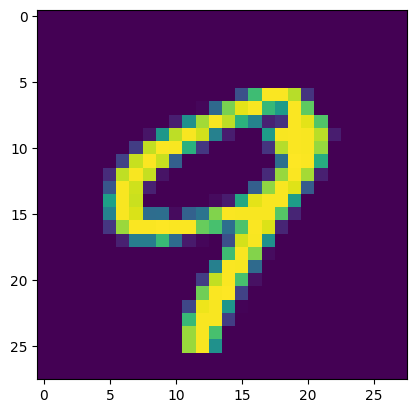

In [21]:
#Visualize Data
plt.imshow(x_train[100][:,:,0])
print(y_train[100])

The image is a handwritten 9. The one-hot encoding suggests the value of 9.

### Build the CNN Model

In [34]:
#Define parameters for model
batch_size = 64
num_classes = 10
epochs = 20

In [23]:
model = tf.keras.models.Sequential([
    Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
    Conv2D(32, (5,5), padding='same', activation='relu'),
    MaxPool2D(),
    Dropout(0.25),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPool2D(strides=(2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer=RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


### Plot Model

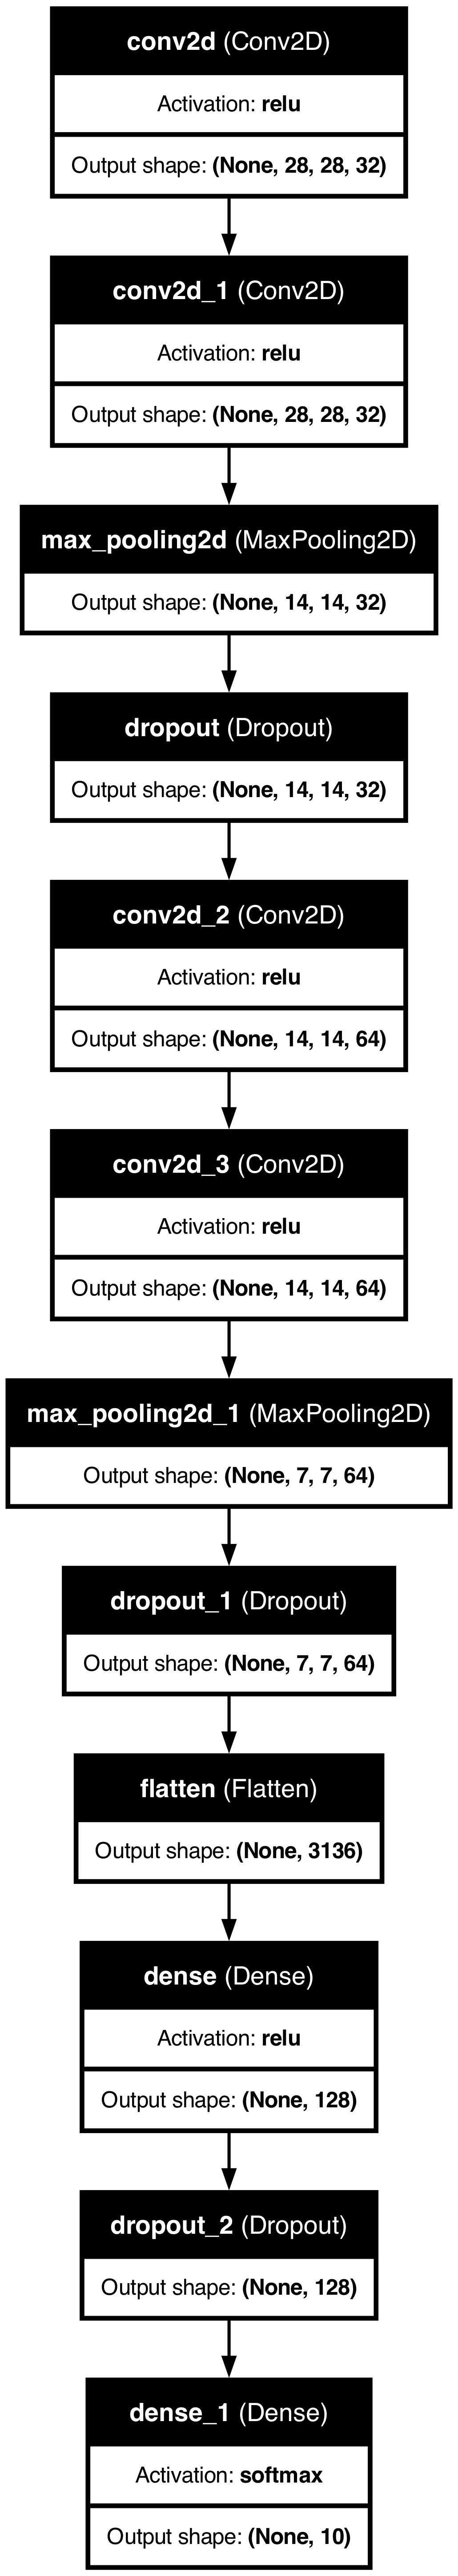

In [30]:
plot_model(model, rankdir='TB',to_file='mnist_cnn.png', dpi=256, show_shapes=True, show_layer_names=True, expand_nested=True, 
                    show_layer_activations=True)

### Fit the Model

In [31]:
# Define callback -> model will stop training if 99.3% accuracy attained

class callback(Callback):
  def training_stopped(self, epoch, logs={}):
    if(logs.get('accuracy')>0.993):
      print("\nTraining stopped, accuracy > 99.3%!")
      self.model.stop_training = True

callbacks = callback()

In [35]:
# Fit training data
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[callbacks])

Epoch 1/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 681s 1s/step - accuracy: 0.9690 - loss: 0.1012 - val_accuracy: 0.9832 - val_loss: 0.0604
Epoch 2/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 462s 880ms/step - accuracy: 0.9809 - loss: 0.0676 - val_accuracy: 0.9894 - val_loss: 0.0332
Epoch 3/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 463s 882ms/step - accuracy: 0.9837 - loss: 0.0533 - val_accuracy: 0.9894 - val_loss: 0.0370
Epoch 4/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 488s 930ms/step - accuracy: 0.9873 - loss: 0.0457 - val_accuracy: 0.9912 - val_loss: 0.0344
Epoch 5/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 473s 902ms/step - accuracy: 0.9886 - loss: 0.0407 - val_accuracy: 0.9919 - val_loss: 0.0341
Epoch 6/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 467s 890ms/step - accuracy: 0.9885 - loss: 0.0381 - val_accuracy: 0.9933 - val_loss: 0.0280
Epoch 7/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 476s 906ms/step - accuracy: 0.9903 - loss: 0.0340 - val_accuracy: 0.9929 - val_loss: 0.0269
Epoch 8/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 490s 933ms/step - accuracy: 0.9896 - lo

### Evaluate Model

Text(0.5, 1.0, 'Train - Accuracy')

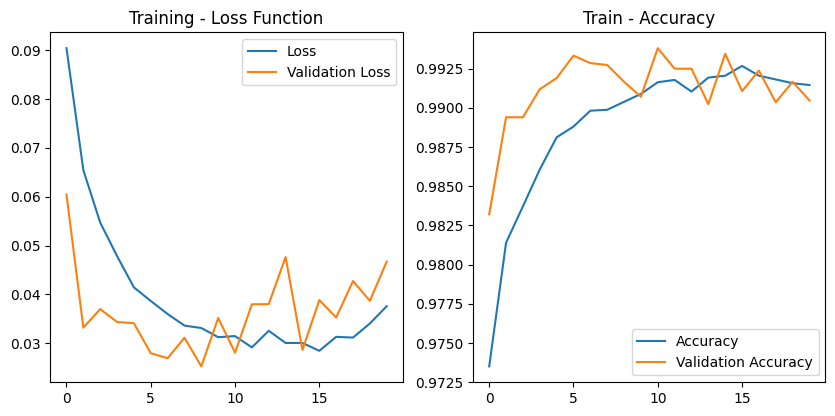

In [36]:
#plot training accuracy vs. loss
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

### Predict Test Data

In [41]:
test_pred = pd.DataFrame(model.predict(x_test))
test_pred = pd.DataFrame(test_pred.idxmax(axis = 1))
test_pred.index.name = 'ImageId'
test_pred = test_pred.rename(columns = {0: 'Label'}).reset_index()
test_pred['ImageId'] = test_pred['ImageId'] + 1

test_pred.head()

875/875 ━━━━━━━━━━━━━━━━━━━━ 112s 128ms/step


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [42]:
test_pred.to_csv('digit_recognizer_submission.csv', index = False)

### prediction accuracy on test data: 99.082% 

Please see document, 'Kaggle_test_prediction_evaluator_cnn_digit_recognizer'
